# Load data

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [2]:
# Load and split data
filename = '../data/bankruptcy.csv'
df = pd.read_csv(filename, sep=',', index_col=False)

# Drop column (always same value)
df.drop(columns=[' Net Income Flag'], inplace=True)

# Drop two outlier rows (encoding errors)
df.drop(df[df[' Revenue per person'] > 1].index, inplace=True)

# Split into X, Y
values = df.values
X, Y = values[:, 1:], values[:, 0]
feature_names = list(df.columns)[1:]

# Train/val/test split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=0)
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, test_size=0.2, random_state=0)

In [3]:
# Neural network pre-processing
enc = OneHotEncoder(sparse=False)
Y_train_oh = enc.fit_transform(np.expand_dims(Y_train, -1))
Y_val_oh = enc.fit_transform(np.expand_dims(Y_val, -1))
Y_test_oh = enc.transform(np.expand_dims(Y_test, -1))

ss = StandardScaler()
ss.fit(X_train)
X_train_std = ss.transform(X_train)
X_val_std = ss.transform(X_val)
X_test_std = ss.transform(X_test)

# Set up imputer

In [4]:
import torch
import fastshap_torch
from fastshap_torch import Surrogate

In [5]:
device = torch.device('cuda', 3)
surrogate = torch.load('../models/bankruptcy_surrogate.pt').eval().to(device)
num_features = X_train.shape[1]
surr = Surrogate(surrogate, num_features)

# Load SHAP values

In [6]:
import pickle
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from fastshap_torch import FastSHAP

In [7]:
with open('../results/bankruptcy_shap.pkl', 'rb') as f:
    shap_values = np.array(pickle.load(f))

In [8]:
def euclidean_dist(values, target):
    return np.sqrt(np.sum((values - target) ** 2, axis=(-2, -1)))

def l1_dist(values, target):
    return np.sum(np.abs(values - target), axis=(-2, -1))

# Samples plot

- Using normalization and the efficiency gap penalty, test different # training samples

In [41]:
# Standard sampling
num_samples = (1, 4, 16, 32, 48, 64)
standard_results = []

for samples in num_samples:
    # Load explainer
    explainer = torch.load('../models/bankruptcy_explainer samples={} nopenalty.pt'.format(samples))
    explainer.eval()
    explainer.to(device=device)
    
    # Set up FastSHAP object
    fastshap = FastSHAP(explainer, surr, normalization='additive', link=nn.Softmax(dim=-1))
    
    # Generate explanations
    pred = fastshap.shap_values(X_test_std[:len(shap_values)])
    standard_results.append(pred)

# Paired sampling
num_paired_samples = (4, 16, 32, 48, 64)
paired_results = []

for samples in num_paired_samples:
    # Load explainer
    explainer = torch.load('../models/bankruptcy_explainer paired_samples={} nopenalty.pt'.format(samples))
    explainer.eval()
    explainer.to(device=device)
    
    # Set up FastSHAP object
    fastshap = FastSHAP(explainer, surr, normalization='additive', link=nn.Softmax(dim=-1))
    
    # Generate explanations
    pred = fastshap.shap_values(X_test_std[:len(shap_values)])
    paired_results.append(pred)

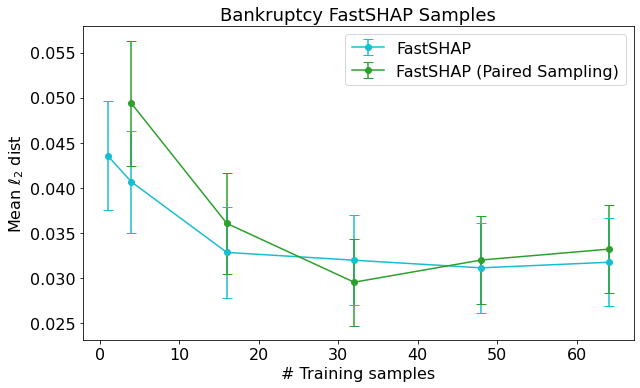

In [42]:
plt.figure(figsize=(9, 5.5))

# Standard sampling
dist_list = [euclidean_dist(results, shap_values) for results in standard_results]
mean_list = [np.mean(dist) for dist in dist_list]
std_list = [np.std(dist) / np.sqrt(len(shap_values)) for dist in dist_list]
plt.errorbar(num_samples, mean_list, yerr=1.96 * np.array(std_list),
             capsize=5, marker='o', color='tab:cyan', label='FastSHAP')

# Paired sampling
dist_list = [euclidean_dist(results, shap_values) for results in paired_results]
mean_list = [np.mean(dist) for dist in dist_list]
std_list = [np.std(dist) / np.sqrt(len(shap_values)) for dist in dist_list]
plt.errorbar(num_paired_samples, mean_list, yerr=1.96 * np.array(std_list),
             capsize=5, marker='o', color='tab:green', label='FastSHAP (Paired Sampling)')

# Formatting
plt.legend(loc='upper right', fontsize=16)
plt.xlabel('# Training samples', fontsize=16)
plt.ylabel(r'Mean $\ell_2$ dist', fontsize=16)
plt.title('Bankruptcy FastSHAP Samples', fontsize=18)
plt.tick_params(labelsize=16)

plt.tight_layout()
# plt.show()
plt.savefig('../figures/bankruptcy_samples.pdf')

# Ablation results

- For a fixed number of samples (with paired sampling), test the normalization layer and the efficiency gap penalty

In [32]:
ablation_results = [
    # {'filename': '../models/bankruptcy_explainer nopenalty.pt', 'name': 'FastSHAP (Norm)'},
    {'filename': '../models/bankruptcy_explainer paired_samples=32 nopenalty.pt', 'name': 'FastSHAP (Norm)'},
    {'filename': '../models/bankruptcy_explainer paired_samples=32.pt', 'name': 'FastSHAP (Norm, Penalty)'},
    {'filename': '../models/bankruptcy_explainer nopenalty nonormalization.pt', 'name': 'FastSHAP (Inference Norm)'},
    {'filename': '../models/bankruptcy_explainer nonormalization.pt', 'name': 'FastSHAP (Inference Norm, Penalty)'},
    {'filename': '../models/bankruptcy_explainer nopenalty nonormalization.pt', 'name': 'FastSHAP (No Norm)'},
    {'filename': '../models/bankruptcy_explainer nonormalization.pt', 'name': 'FastSHAP (No Norm, Penalty)'},
]

for ablation in ablation_results:
    # Load explainer
    explainer = torch.load(ablation['filename'])
    explainer.eval()
    explainer.to(device=device)
    
    # Set up FastSHAP object
    if 'No Norm' in ablation['name']:
        normalization = None
    else:
        normalization = 'additive'
    fastshap = FastSHAP(explainer, surr, normalization=normalization, link=nn.Softmax(dim=-1))
    
    # Generate explanations
    pred = fastshap.shap_values(X_test_std[:len(shap_values)])
    ablation['results'] = pred

In [33]:
print(r' & $\ell_2$ & $\ell_1$')

for ablation in ablation_results:
    # Calculate distance
    l2 = euclidean_dist(ablation['results'], shap_values)
    l1 = l1_dist(ablation['results'], shap_values)
    
    # Print results
    print('{} & {:.4f} & {:.4f}'.format(ablation['name'], np.mean(l2), np.mean(l1)))

 & $\ell_2$ & $\ell_1$
FastSHAP (Norm) & 0.0295 & 0.2436
FastSHAP (Norm, Penalty) & 0.0320 & 0.2740
FastSHAP (Inference Norm) & 0.0407 & 0.3450
FastSHAP (Inference Norm, Penalty) & 0.0473 & 0.4471
FastSHAP (No Norm) & 0.0408 & 0.3474
FastSHAP (No Norm, Penalty) & 0.0474 & 0.4490


In [34]:
print(r' & $\ell_2$ & $\ell_1$')

for ablation in ablation_results:
    # Calculate distance
    l2 = euclidean_dist(ablation['results'], shap_values)
    l1 = l1_dist(ablation['results'], shap_values)
    
    # Print results
    print('{} & {:.4f} $\pm$ {:.4f} & {:.4f} $\pm$ {:.4f}'.format(
        ablation['name'],
        np.mean(l2), 1.96 * np.std(l2) / np.sqrt(len(shap_values)),
        np.mean(l1), 1.96 * np.std(l1) / np.sqrt(len(shap_values))))

 & $\ell_2$ & $\ell_1$
FastSHAP (Norm) & 0.0295 $\pm$ 0.0048 & 0.2436 $\pm$ 0.0304
FastSHAP (Norm, Penalty) & 0.0320 $\pm$ 0.0051 & 0.2740 $\pm$ 0.0334
FastSHAP (Inference Norm) & 0.0407 $\pm$ 0.0064 & 0.3450 $\pm$ 0.0496
FastSHAP (Inference Norm, Penalty) & 0.0473 $\pm$ 0.0063 & 0.4471 $\pm$ 0.0522
FastSHAP (No Norm) & 0.0408 $\pm$ 0.0064 & 0.3474 $\pm$ 0.0495
FastSHAP (No Norm, Penalty) & 0.0474 $\pm$ 0.0063 & 0.4490 $\pm$ 0.0523


# Curve comparison

In [43]:
# Load curves
with open('../results/bankruptcy_curves.pkl', 'rb') as f:
    save_dict = pickle.load(f)
    
kernelshap_curves = save_dict['kernelshap']
kernelshap_iters = save_dict['kernelshap_iters']

paired_curves = save_dict['paired_sampling']
paired_iters = save_dict['paired_sampling_iters']

sampling_curves = save_dict['sampling_curves']
sampling_iters = save_dict['sampling_iters']

antithetical_curves = save_dict['antithetical_curves']
antithetical_iters = save_dict['antithetical_iters']

In [44]:
# Load FastSHAP
explainer = torch.load('../models/bankruptcy_explainer paired_samples=32 nopenalty.pt')
explainer.eval()
explainer.to(device=device)

# Set up FastSHAP object
fastshap = FastSHAP(explainer, surr, normalization='additive', link=nn.Softmax(dim=-1))

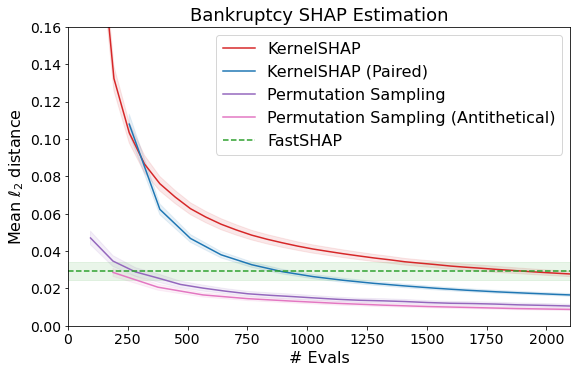

In [45]:
plt.figure(figsize=(9, 5.5))

# KernelSHAP
dist = euclidean_dist(kernelshap_curves, shap_values[:, np.newaxis])
skip_inds = 1
plt.plot(kernelshap_iters[skip_inds:], np.mean(dist, axis=0)[skip_inds:],
         label='KernelSHAP', color='tab:red')
plt.fill_between(kernelshap_iters[skip_inds:],
                 (np.mean(dist, axis=0) - 1.96 * np.std(dist, axis=0) / np.sqrt(len(shap_values)))[skip_inds:],
                 (np.mean(dist, axis=0) + 1.96 * np.std(dist, axis=0) / np.sqrt(len(shap_values)))[skip_inds:],
                 color='tab:red', alpha=0.1)

# KernelSHAP (paired sampling)
dist = euclidean_dist(paired_curves, shap_values[:, np.newaxis])
skip_inds = 1
plt.plot(paired_iters[skip_inds:], np.mean(dist, axis=0)[skip_inds:],
         label='KernelSHAP (Paired)', color='tab:blue')
plt.fill_between(paired_iters[skip_inds:],
                 (np.mean(dist, axis=0) - 1.96 * np.std(dist, axis=0) / np.sqrt(len(shap_values)))[skip_inds:],
                 (np.mean(dist, axis=0) + 1.96 * np.std(dist, axis=0) / np.sqrt(len(shap_values)))[skip_inds:],
                 color='tab:blue', alpha=0.1)

# Permutation sampling
dist = euclidean_dist(sampling_curves, shap_values[:, np.newaxis])
plt.plot(sampling_iters, np.mean(dist, axis=0),
         label='Permutation Sampling', color='tab:purple')
plt.fill_between(sampling_iters,
                 np.mean(dist, axis=0) - 1.96 * np.std(dist, axis=0) / np.sqrt(len(shap_values)),
                 np.mean(dist, axis=0) + 1.96 * np.std(dist, axis=0) / np.sqrt(len(shap_values)),
                 color='tab:purple', alpha=0.1)

# Antithetical sampling
dist = euclidean_dist(antithetical_curves, shap_values[:, np.newaxis])
plt.plot(antithetical_iters, np.mean(dist, axis=0),
         label='Permutation Sampling (Antithetical)', color='tab:pink')
plt.fill_between(antithetical_iters,
                 np.mean(dist, axis=0) - 1.96 * np.std(dist, axis=0) / np.sqrt(len(shap_values)),
                 np.mean(dist, axis=0) + 1.96 * np.std(dist, axis=0) / np.sqrt(len(shap_values)),
                 color='tab:pink', alpha=0.1)

# FastSHAP
pred = fastshap.shap_values(X_test_std[:len(shap_values)])
dist = euclidean_dist(pred, shap_values)
plt.axhline(np.mean(dist), label='FastSHAP', color='tab:green', linestyle='--')
plt.fill_between([0, 2100],
                 [np.mean(dist, axis=0) - 1.96 * np.std(dist, axis=0) / np.sqrt(len(shap_values)),
                  np.mean(dist, axis=0) - 1.96 * np.std(dist, axis=0) / np.sqrt(len(shap_values))],
                 [np.mean(dist, axis=0) + 1.96 * np.std(dist, axis=0) / np.sqrt(len(shap_values)),
                  np.mean(dist, axis=0) + 1.96 * np.std(dist, axis=0) / np.sqrt(len(shap_values))],
                 color='tab:green', alpha=0.1)

# Formatting
plt.ylim(0, 0.16)
plt.xlim(0, 2100)
plt.legend(fontsize=16)
plt.tick_params(labelsize=14)
plt.ylabel(r'Mean $\ell_2$ distance', fontsize=16)
plt.xlabel('# Evals', fontsize=16)
plt.title('Bankruptcy SHAP Estimation', fontsize=18)

# plt.show()
plt.savefig('../figures/bankruptcy_l2_curves.pdf')

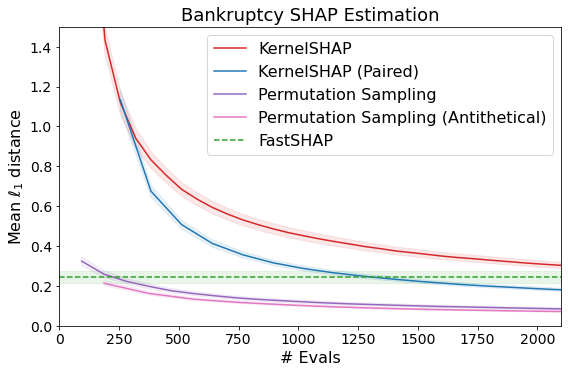

In [46]:
plt.figure(figsize=(9, 5.5))

# KernelSHAP
dist = l1_dist(kernelshap_curves, shap_values[:, np.newaxis])
skip_inds = 1
plt.plot(kernelshap_iters[skip_inds:], np.mean(dist, axis=0)[skip_inds:],
         label='KernelSHAP', color='tab:red')
plt.fill_between(kernelshap_iters[skip_inds:],
                 (np.mean(dist, axis=0) - 1.96 * np.std(dist, axis=0) / np.sqrt(len(shap_values)))[skip_inds:],
                 (np.mean(dist, axis=0) + 1.96 * np.std(dist, axis=0) / np.sqrt(len(shap_values)))[skip_inds:],
                 color='tab:red', alpha=0.1)

# KernelSHAP (paired sampling)
dist = l1_dist(paired_curves, shap_values[:, np.newaxis])
skip_inds = 1
plt.plot(paired_iters[skip_inds:], np.mean(dist, axis=0)[skip_inds:],
         label='KernelSHAP (Paired)', color='tab:blue')
plt.fill_between(paired_iters[skip_inds:],
                 (np.mean(dist, axis=0) - 1.96 * np.std(dist, axis=0) / np.sqrt(len(shap_values)))[skip_inds:],
                 (np.mean(dist, axis=0) + 1.96 * np.std(dist, axis=0) / np.sqrt(len(shap_values)))[skip_inds:],
                 color='tab:blue', alpha=0.1)

# Permutation sampling
dist = l1_dist(sampling_curves, shap_values[:, np.newaxis])
plt.plot(sampling_iters, np.mean(dist, axis=0),
         label='Permutation Sampling', color='tab:purple')
plt.fill_between(sampling_iters,
                 np.mean(dist, axis=0) - 1.96 * np.std(dist, axis=0) / np.sqrt(len(shap_values)),
                 np.mean(dist, axis=0) + 1.96 * np.std(dist, axis=0) / np.sqrt(len(shap_values)),
                 color='tab:purple', alpha=0.1)

# Antithetical sampling
dist = l1_dist(antithetical_curves, shap_values[:, np.newaxis])
plt.plot(antithetical_iters, np.mean(dist, axis=0),
         label='Permutation Sampling (Antithetical)', color='tab:pink')
plt.fill_between(antithetical_iters,
                 np.mean(dist, axis=0) - 1.96 * np.std(dist, axis=0) / np.sqrt(len(shap_values)),
                 np.mean(dist, axis=0) + 1.96 * np.std(dist, axis=0) / np.sqrt(len(shap_values)),
                 color='tab:pink', alpha=0.1)

# FastSHAP
pred = fastshap.shap_values(X_test_std[:len(shap_values)])
dist = l1_dist(pred, shap_values)
plt.axhline(np.mean(dist), label='FastSHAP', color='tab:green', linestyle='--')
plt.fill_between([0, 2100],
                 [np.mean(dist, axis=0) - 1.96 * np.std(dist, axis=0) / np.sqrt(len(shap_values)),
                  np.mean(dist, axis=0) - 1.96 * np.std(dist, axis=0) / np.sqrt(len(shap_values))],
                 [np.mean(dist, axis=0) + 1.96 * np.std(dist, axis=0) / np.sqrt(len(shap_values)),
                  np.mean(dist, axis=0) + 1.96 * np.std(dist, axis=0) / np.sqrt(len(shap_values))],
                 color='tab:green', alpha=0.1)

# Formatting
plt.ylim(0, 1.5)
plt.xlim(0, 2100)
plt.legend(fontsize=16)
plt.tick_params(labelsize=14)
plt.ylabel(r'Mean $\ell_1$ distance', fontsize=16)
plt.xlabel('# Evals', fontsize=16)
plt.title('Bankruptcy SHAP Estimation', fontsize=18)

# plt.show()
plt.savefig('../figures/bankruptcy_l1_curves.pdf')

# Catch up plot

- Botplot of # model evaluations required to catch up to FastSHAP

In [18]:
# Get FastSHAP distances
fast_dist = euclidean_dist(pred, shap_values)

# Set up baselines
catchup_results = [
    {'name': 'KernelSHAP', 'estimates': kernelshap_curves, 'iters': kernelshap_iters},
    {'name': 'KernelSHAP (Paired)', 'estimates': paired_curves, 'iters': paired_iters},
    {'name': 'Sampling', 'estimates': sampling_curves, 'iters': sampling_iters},
    {'name': 'Sampling (Anti)', 'estimates': antithetical_curves, 'iters': antithetical_iters}
]

# Calculate number of iterations required for each baseline
for results in catchup_results:
    # Calculate distance
    estimates = results['estimates']
    iters = results['iters']
    dist = euclidean_dist(estimates, shap_values[:, np.newaxis])
    
    # Find index where distance becomes smaller
    smaller = dist < fast_dist[:, np.newaxis]
    smaller[:, -1] = True
    index = np.argmax(smaller, axis=1)
    results['catchup_iters'] = iters[index]

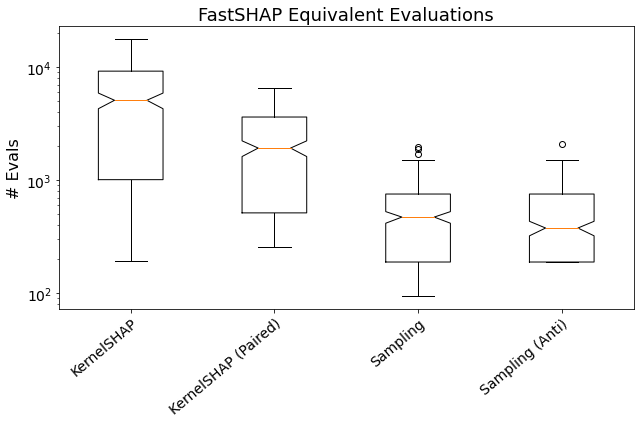

In [19]:
plt.figure(figsize=(9, 6))

# Plot
plt.boxplot([results['catchup_iters'] for results in catchup_results],
            notch=True, vert=True)
plt.xticks(1 + np.arange(len(catchup_results)), [results['name'] for results in catchup_results],
           rotation=40, ha='right', rotation_mode='anchor')

# Formatting
plt.ylabel('# Evals', fontsize=16)
plt.yscale('log')
plt.title('FastSHAP Equivalent Evaluations', fontsize=18)
plt.tick_params(labelsize=14)

plt.tight_layout()
plt.show()

In [47]:
# Calculate mean catchup time
catchup_results = {}

# FastSHAP
pred = fastshap.shap_values(X_test_std[:len(shap_values)])
dist = euclidean_dist(pred, shap_values)
mean_dist = np.mean(dist)

# KernelSHAP
iters = kernelshap_iters
dist = np.mean(euclidean_dist(kernelshap_curves, shap_values[:, np.newaxis]), axis=0)
ind = np.where(dist < mean_dist)[0][0]
if ind == 0:
    # Minimum number of iterations
    catchup_results['KernelSHAP'] = iters[ind]
else:
    # Linear interpolation
    w = (dist[ind - 1] - mean_dist) / (dist[ind - 1] - dist[ind])
    catchup_results['KernelSHAP'] = iters[ind - 1] + w * (iters[ind] - iters[ind - 1])

# KernelSHAP (paired sampling)
iters = paired_iters
dist = np.mean(euclidean_dist(paired_curves, shap_values[:, np.newaxis]), axis=0)
ind = np.where(dist < mean_dist)[0][0]
if ind == 0:
    # Minimum number of iterations
    catchup_results['KernelSHAP (Paired)'] = iters[ind]
else:
    # Linear interpolation
    w = (dist[ind - 1] - mean_dist) / (dist[ind - 1] - dist[ind])
    catchup_results['KernelSHAP (Paired)'] = iters[ind - 1] + w * (iters[ind] - iters[ind - 1])

# Permutation sampling
iters = sampling_iters
dist = np.mean(euclidean_dist(sampling_curves, shap_values[:, np.newaxis]), axis=0)
ind = np.where(dist < mean_dist)[0][0]
if ind == 0:
    # Minimum number of iterations
    catchup_results['Permutation Sampling'] = iters[ind]
else:
    # Linear interpolation
    w = (dist[ind - 1] - mean_dist) / (dist[ind - 1] - dist[ind])
    catchup_results['Permutation Sampling'] = iters[ind - 1] + w * (iters[ind] - iters[ind - 1])

# Anithetical sampling
iters = antithetical_iters
dist = np.mean(euclidean_dist(antithetical_curves, shap_values[:, np.newaxis]), axis=0)
ind = np.where(dist < mean_dist)[0][0]
if ind == 0:
    # Minimum number of iterations
    catchup_results['Permutation Sampling (Antithetical)'] = iters[ind]
else:
    # Linear interpolation
    w = (dist[ind - 1] - mean_dist) / (dist[ind - 1] - dist[ind])
    catchup_results['Permutation Sampling (Antithetical)'] = iters[ind - 1] + w * (iters[ind] - iters[ind - 1])

In [49]:
with open('../results/bankruptcy_catchup.pkl', 'wb') as f:
    pickle.dump(catchup_results, f)